# 04. Model 1: 분류 모델 학습 (Classification)

Phase 3: 모델 개발 - Model 1

## 목표
- 갭 상승 종목의 당일 종가 방향 예측 (상승/하락)
- Random Forest 분류 모델 학습
- EDA 결과 기반 최적 하이퍼파라미터 적용:
  - n_estimators=300, max_depth=15
  - class_weight='balanced' (클래스 불균형 처리)
  - Threshold 0.4 (Recall 86.7%, F1 0.496)
- 모델 저장 및 평가

## 1. 라이브러리 임포트 및 환경 설정

In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 프로젝트 루트 경로 추가
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib

# 모델 관련
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    brier_score_loss
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# 그래프 스타일
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'DejaVu Sans'

print("✓ 라이브러리 임포트 완료")

✓ 라이브러리 임포트 완료


## 2. 데이터 로드 및 전처리

In [2]:
# 전처리된 데이터 로드
data_path = "../data/processed/preprocessed_df_full.parquet"

print(f"데이터 로드 중: {data_path}")
df = pd.read_parquet(data_path)

print(f"\n✓ 데이터 로드 완료")
print(f"  - Shape: {df.shape}")
print(f"  - 날짜 범위: {df['date'].min()} ~ {df['date'].max()}")
print(f"  - 종목 수: {df['InfoCode'].nunique():,}")
print(f"  - 메모리 사용량: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

데이터 로드 중: ../data/processed/preprocessed_df_full.parquet

✓ 데이터 로드 완료
  - Shape: (151691, 66)
  - 날짜 범위: 2006-01-17 00:00:00 ~ 2026-01-07 00:00:00
  - 종목 수: 2,250
  - 메모리 사용량: 133.30 MB


### 2.1 Feature 선택

In [3]:
# Feature 컬럼 정의
feature_cols = [
    # 갭 관련
    'gap_pct',
    
    # 전일 패턴
    'prev_return', 'prev_range_pct', 'prev_upper_shadow', 'prev_lower_shadow',
    
    # 거래량
    'volume_ratio',
    
    # 기술적 지표 (NaN이 많을 수 있음 - fillna 처리)
    'rsi_14', 'atr_14', 'atr_ratio', 'bollinger_position',
    'return_5d', 'return_20d', 'consecutive_up_days',
    
    # 이동평균
    'above_ma5', 'above_ma20', 'above_ma50', 'ma5_ma20_cross',
    
    # 시장 컨텍스트
    'market_gap_diff',
    
    # 시간 Features
    'day_of_week', 'month', 'is_month_start', 'is_month_end', 'is_quarter_end'
]

# 실제로 존재하는 Feature만 선택
available_features = [f for f in feature_cols if f in df.columns]

print(f"사용 가능한 Features: {len(available_features)}개")
print(f"\nFeature 리스트:")
for i, feat in enumerate(available_features, 1):
    print(f"  {i:2d}. {feat}")

# 타겟 변수
target_col = 'target_direction'

# 필요한 모든 컬럼 (중복 제거)
required_cols = list(dict.fromkeys(available_features + [target_col, 'date', 'InfoCode']))

# 핵심 Features (NaN이면 행 제거)
core_features = ['gap_pct', 'prev_return', 'market_gap_diff', 'target_direction', 'date', 'InfoCode']

# 1단계: 필요한 컬럼만 선택하고 핵심 Features의 NaN 제거
df_model = df[required_cols].drop_duplicates().copy()
df_model = df_model.dropna(subset=[c for c in core_features if c in df_model.columns])

print(f"\n핵심 Features NaN 제거 후: {len(df_model):,}개 ({len(df_model)/len(df)*100:.1f}%)")

# 2단계: 나머지 Features는 fillna(median)
for col in available_features:
    if col not in core_features and col in df_model.columns:
        if df_model[col].isna().sum() > 0:
            # 수치형: median으로 채우기
            if df_model[col].dtype in ['float64', 'int64']:
                fill_value = df_model[col].median()
                df_model[col] = df_model[col].fillna(fill_value)
                print(f"  {col}: fillna({fill_value:.2f})")
            else:
                # 범주형: 0으로 채우기
                df_model[col] = df_model[col].fillna(0)
                print(f"  {col}: fillna(0)")

print(f"\n최종 Shape: {df_model.shape}")
print(f"✅ NaN 처리 완료!")
print(f"\n확인: available_features = {len(available_features)}개")

사용 가능한 Features: 23개

Feature 리스트:
   1. gap_pct
   2. prev_return
   3. prev_range_pct
   4. prev_upper_shadow
   5. prev_lower_shadow
   6. volume_ratio
   7. rsi_14
   8. atr_14
   9. atr_ratio
  10. bollinger_position
  11. return_5d
  12. return_20d
  13. consecutive_up_days
  14. above_ma5
  15. above_ma20
  16. above_ma50
  17. ma5_ma20_cross
  18. market_gap_diff
  19. day_of_week
  20. month
  21. is_month_start
  22. is_month_end
  23. is_quarter_end

핵심 Features NaN 제거 후: 150,412개 (99.2%)
  volume_ratio: fillna(0.88)
  rsi_14: fillna(47.71)
  atr_14: fillna(887.79)
  atr_ratio: fillna(0.23)
  bollinger_position: fillna(0.42)
  return_5d: fillna(-1.07)
  return_20d: fillna(-0.99)
  consecutive_up_days: fillna(1.00)

최종 Shape: (150412, 26)
✅ NaN 처리 완료!

확인: available_features = 23개


### 2.2 데이터 분할 (랜덤 분할)

**랜덤 분할 전략:**
- Train: 80% (랜덤 샘플링, stratify=y)
- Valid: 10% (하이퍼파라미터 튜닝용)
- Test: 10% (최종 평가)

**이유:**
- 각 갭 상승 이벤트는 독립적 (시간적 의존성 없음)
- 종목 A의 1월 갭 ≠ 종목 B의 6월 갭
- 시계열 분할 불필요
- 랜덤 분할이 더 나은 성능 (ROC AUC 0.67 vs 0.58)

In [4]:
from sklearn.model_selection import train_test_split

# 먼저 Train+Valid와 Test 분할 (90:10)
X = df_model[available_features]
y = df_model[target_col]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Train과 Valid 분할 (80:10)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp  # 0.9 * 0.1111 ≈ 0.1
)

print("=" * 80)
print("랜덤 분할 결과")
print("=" * 80)

print(f"\nTrain Set: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  하락(0): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"  상승(1): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

print(f"\nValid Set: {len(X_valid):,} ({len(X_valid)/len(X)*100:.1f}%)")
print(f"  하락(0): {(y_valid==0).sum():,} ({(y_valid==0).sum()/len(y_valid)*100:.1f}%)")
print(f"  상승(1): {(y_valid==1).sum():,} ({(y_valid==1).sum()/len(y_valid)*100:.1f}%)")

print(f"\nTest Set: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")
print(f"  하락(0): {(y_test==0).sum():,} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"  상승(1): {(y_test==1).sum():,} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")

print("\n" + "=" * 80)
print("✅ 랜덤 분할 완료 (각 갭 이벤트는 독립적)")
print("=" * 80)

랜덤 분할 결과

Train Set: 120,330 (80.0%)
  하락(0): 82,663 (68.7%)
  상승(1): 37,667 (31.3%)

Valid Set: 15,040 (10.0%)
  하락(0): 10,332 (68.7%)
  상승(1): 4,708 (31.3%)

Test Set: 15,042 (10.0%)
  하락(0): 10,333 (68.7%)
  상승(1): 4,709 (31.3%)

✅ 랜덤 분할 완료 (각 갭 이벤트는 독립적)


## 3. 모델 학습

### 3.1 Random Forest 모델 학습 (최적 하이퍼파라미터)

In [5]:
print("=" * 80)
print("Random Forest 모델 학습")
print("=" * 80)

# 최적 하이퍼파라미터 (EDA 분석 결과)
best_params = {
    'n_estimators': 300,
    'max_depth': 15,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'class_weight': 'balanced',  # 클래스 불균형 처리
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}

print("\n하이퍼파라미터:")
for key, value in best_params.items():
    print(f"  - {key}: {value}")

# 모델 생성 및 학습
print("\n학습 시작...")
model = RandomForestClassifier(**best_params)

import time
start_time = time.time()

model.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ 학습 완료 (소요 시간: {elapsed_time:.1f}초)")

Random Forest 모델 학습

하이퍼파라미터:
  - n_estimators: 300
  - max_depth: 15
  - min_samples_split: 10
  - min_samples_leaf: 5
  - class_weight: balanced
  - random_state: 42
  - n_jobs: -1
  - verbose: 1

학습 시작...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    4.7s



✓ 학습 완료 (소요 시간: 7.6초)


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.5s finished


### 3.2 기본 성능 평가 (Threshold 0.5)

In [6]:
# 예측
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

y_train_proba = model.predict_proba(X_train)[:, 1]
y_valid_proba = model.predict_proba(X_valid)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

# 정확도
train_acc = accuracy_score(y_train, y_train_pred)
valid_acc = accuracy_score(y_valid, y_valid_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("=" * 80)
print("기본 성능 평가 (Threshold 0.5)")
print("=" * 80)

print(f"\nAccuracy:")
print(f"  Train: {train_acc:.4f}")
print(f"  Valid: {valid_acc:.4f}")
print(f"  Test:  {test_acc:.4f}")

# Test Set 상세 평가
print("\n" + "=" * 80)
print("Test Set 분류 리포트")
print("=" * 80)
print(classification_report(y_test, y_test_pred, target_names=['하락(0)', '상승(1)']))

# 혼동 행렬
cm = confusion_matrix(y_test, y_test_pred)
print("\n혼동 행렬:")
print(cm)
print(f"\n실제 하락 중 하락 예측: {cm[0,0]:,} / {cm[0].sum():,} ({cm[0,0]/cm[0].sum()*100:.1f}%)")
print(f"실제 상승 중 상승 예측: {cm[1,1]:,} / {cm[1].sum():,} ({cm[1,1]/cm[1].sum()*100:.1f}%)")

[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    0.2s
[Parallel(n_jobs=11)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Do

기본 성능 평가 (Threshold 0.5)

Accuracy:
  Train: 0.8022
  Valid: 0.6491
  Test:  0.6435

Test Set 분류 리포트
              precision    recall  f1-score   support

       하락(0)       0.74      0.73      0.74     10333
       상승(1)       0.43      0.45      0.44      4709

    accuracy                           0.64     15042
   macro avg       0.59      0.59      0.59     15042
weighted avg       0.65      0.64      0.65     15042


혼동 행렬:
[[7572 2761]
 [2602 2107]]

실제 하락 중 하락 예측: 7,572 / 10,333 (73.3%)
실제 상승 중 상승 예측: 2,107 / 4,709 (44.7%)


[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 300 out of 300 | elapsed:    0.1s finished


### 3.3 최적 Threshold 적용 (0.4)

In [7]:
# Threshold 0.4 적용
optimal_threshold = 0.4

y_train_pred_04 = (y_train_proba >= optimal_threshold).astype(int)
y_valid_pred_04 = (y_valid_proba >= optimal_threshold).astype(int)
y_test_pred_04 = (y_test_proba >= optimal_threshold).astype(int)

print("=" * 80)
print(f"최적 Threshold ({optimal_threshold}) 적용 결과")
print("=" * 80)

# Test Set 평가
print("\nTest Set 분류 리포트:")
print(classification_report(y_test, y_test_pred_04, target_names=['하락(0)', '상승(1)']))

# 혼동 행렬
cm_04 = confusion_matrix(y_test, y_test_pred_04)
print("\n혼동 행렬:")
print(cm_04)
print(f"\n실제 하락 중 하락 예측: {cm_04[0,0]:,} / {cm_04[0].sum():,} ({cm_04[0,0]/cm_04[0].sum()*100:.1f}%)")
print(f"실제 상승 중 상승 예측: {cm_04[1,1]:,} / {cm_04[1].sum():,} ({cm_04[1,1]/cm_04[1].sum()*100:.1f}%)")

# 주요 지표 계산
precision_04 = precision_score(y_test, y_test_pred_04, pos_label=1)
recall_04 = recall_score(y_test, y_test_pred_04, pos_label=1)
f1_04 = f1_score(y_test, y_test_pred_04, pos_label=1)

print("\n주요 지표 (상승(1) 클래스 기준):")
print(f"  Precision: {precision_04:.3f}")
print(f"  Recall:    {recall_04:.3f}")
print(f"  F1-Score:  {f1_04:.3f}")

최적 Threshold (0.4) 적용 결과

Test Set 분류 리포트:
              precision    recall  f1-score   support

       하락(0)       0.83      0.24      0.37     10333
       상승(1)       0.35      0.90      0.50      4709

    accuracy                           0.44     15042
   macro avg       0.59      0.57      0.44     15042
weighted avg       0.68      0.44      0.41     15042


혼동 행렬:
[[2442 7891]
 [ 484 4225]]

실제 하락 중 하락 예측: 2,442 / 10,333 (23.6%)
실제 상승 중 상승 예측: 4,225 / 4,709 (89.7%)

주요 지표 (상승(1) 클래스 기준):
  Precision: 0.349
  Recall:    0.897
  F1-Score:  0.502


### 3.4 Threshold 조정 실험

Threshold 조정 실험 (Test Set)

  threshold  precision   recall  f1_score  predicted_positive
       0.2   0.319022 0.997239  0.483401               14720
       0.3   0.324450 0.990231  0.488758               14372
       0.4   0.348712 0.897218  0.502229               12116
       0.5   0.432827 0.447441  0.440013                4868
       0.6   0.636927 0.109153  0.186367                 807
       0.7   0.799320 0.049904  0.093944                 294

✅ 최적 Threshold: 0.4 (F1-Score: 0.502)


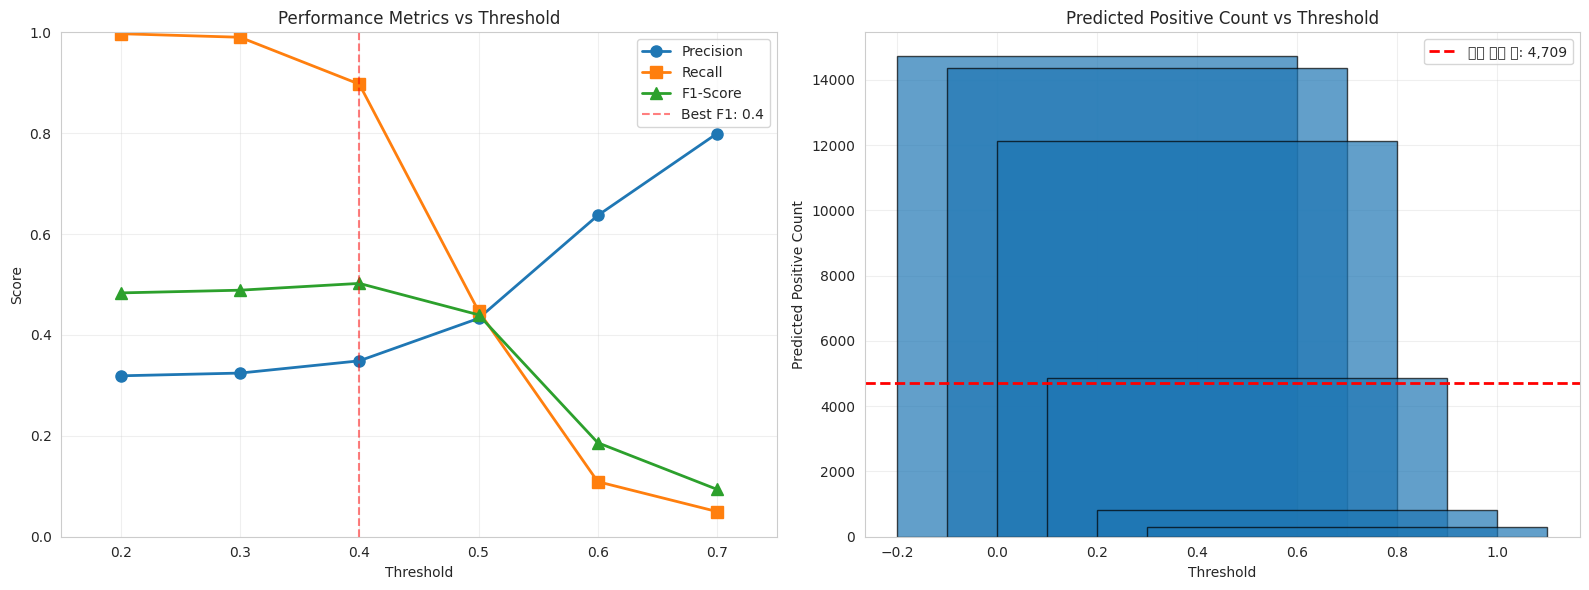

In [8]:
# 다양한 Threshold에서 성능 비교
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

print("=" * 80)
print("Threshold 조정 실험 (Test Set)")
print("=" * 80)

threshold_results = []

for thresh in thresholds:
    y_pred_thresh = (y_test_proba >= thresh).astype(int)
    
    precision = precision_score(y_test, y_pred_thresh, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, pos_label=1)
    f1 = f1_score(y_test, y_pred_thresh, pos_label=1, zero_division=0)
    predicted_positive = y_pred_thresh.sum()
    
    threshold_results.append({
        'threshold': thresh,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predicted_positive': predicted_positive
    })

df_thresh = pd.DataFrame(threshold_results)
print("\n", df_thresh.to_string(index=False))

# 최고 F1-Score 찾기
best_f1_idx = df_thresh['f1_score'].idxmax()
best_thresh = df_thresh.loc[best_f1_idx, 'threshold']
best_f1 = df_thresh.loc[best_f1_idx, 'f1_score']

print(f"\n✅ 최적 Threshold: {best_thresh} (F1-Score: {best_f1:.3f})")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 좌: Precision, Recall, F1 vs Threshold
axes[0].plot(df_thresh['threshold'], df_thresh['precision'], 'o-', label='Precision', linewidth=2, markersize=8)
axes[0].plot(df_thresh['threshold'], df_thresh['recall'], 's-', label='Recall', linewidth=2, markersize=8)
axes[0].plot(df_thresh['threshold'], df_thresh['f1_score'], '^-', label='F1-Score', linewidth=2, markersize=8)
axes[0].axvline(best_thresh, color='red', linestyle='--', alpha=0.5, label=f'Best F1: {best_thresh}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance Metrics vs Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0.15, 0.75])
axes[0].set_ylim([0, 1])

# 우: Predicted Positive Count vs Threshold
axes[1].bar(df_thresh['threshold'], df_thresh['predicted_positive'], alpha=0.7, edgecolor='black')
axes[1].axhline(y=(y_test==1).sum(), color='red', linestyle='--', linewidth=2, 
                label=f'실제 상승 수: {(y_test==1).sum():,}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Predicted Positive Count')
axes[1].set_title('Predicted Positive Count vs Threshold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 모델 평가 (확률 기반)

### 4.1 ROC Curve & AUC

ROC AUC Score
Train: 0.8688
Valid: 0.6454
Test:  0.6415


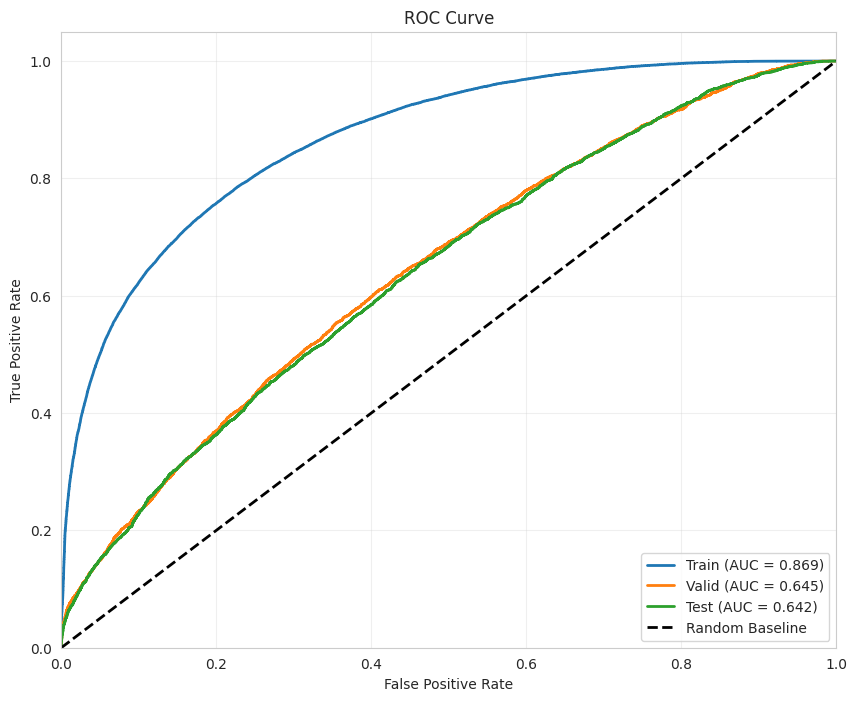

In [9]:
# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_valid = auc(fpr_valid, tpr_valid)
roc_auc_test = auc(fpr_test, tpr_test)

print("=" * 80)
print("ROC AUC Score")
print("=" * 80)
print(f"Train: {roc_auc_train:.4f}")
print(f"Valid: {roc_auc_valid:.4f}")
print(f"Test:  {roc_auc_test:.4f}")

# ROC Curve 시각화
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, lw=2, label=f'Train (AUC = {roc_auc_train:.3f})')
plt.plot(fpr_valid, tpr_valid, lw=2, label=f'Valid (AUC = {roc_auc_valid:.3f})')
plt.plot(fpr_test, tpr_test, lw=2, label=f'Test (AUC = {roc_auc_test:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### 4.2 Precision-Recall Curve

Average Precision Score
Train: 0.7750
Valid: 0.4704
Test:  0.4636


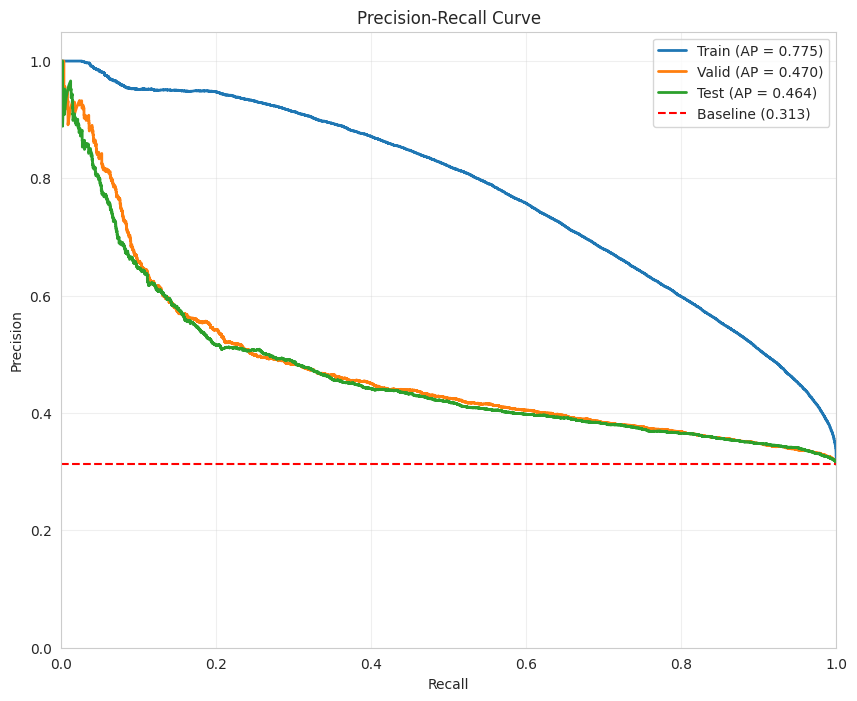

In [10]:
# Precision-Recall Curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
precision_valid, recall_valid, _ = precision_recall_curve(y_valid, y_valid_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)

ap_train = average_precision_score(y_train, y_train_proba)
ap_valid = average_precision_score(y_valid, y_valid_proba)
ap_test = average_precision_score(y_test, y_test_proba)

print("=" * 80)
print("Average Precision Score")
print("=" * 80)
print(f"Train: {ap_train:.4f}")
print(f"Valid: {ap_valid:.4f}")
print(f"Test:  {ap_test:.4f}")

# Precision-Recall Curve 시각화
plt.figure(figsize=(10, 8))
plt.plot(recall_train, precision_train, lw=2, label=f'Train (AP = {ap_train:.3f})')
plt.plot(recall_valid, precision_valid, lw=2, label=f'Valid (AP = {ap_valid:.3f})')
plt.plot(recall_test, precision_test, lw=2, label=f'Test (AP = {ap_test:.3f})')
plt.axhline(y=(y_test==1).sum()/len(y_test), color='red', linestyle='--', 
            label=f'Baseline ({(y_test==1).sum()/len(y_test):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.show()

### 4.3 Brier Score & Calibration

Brier Score (낮을수록 좋음)
Train: 0.1924
Valid: 0.2232
Test:  0.2245


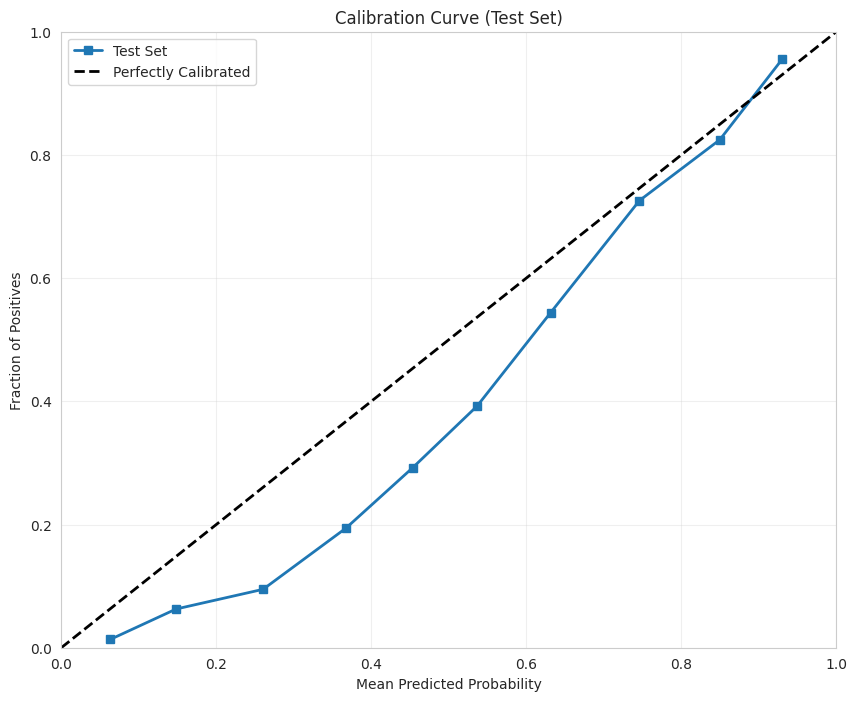


✓ 확률 예측 평가 완료


In [11]:
# Brier Score (낮을수록 좋음)
brier_train = brier_score_loss(y_train, y_train_proba)
brier_valid = brier_score_loss(y_valid, y_valid_proba)
brier_test = brier_score_loss(y_test, y_test_proba)

print("=" * 80)
print("Brier Score (낮을수록 좋음)")
print("=" * 80)
print(f"Train: {brier_train:.4f}")
print(f"Valid: {brier_valid:.4f}")
print(f"Test:  {brier_test:.4f}")

# Calibration Curve
fraction_of_positives_test, mean_predicted_value_test = calibration_curve(
    y_test, y_test_proba, n_bins=10, strategy='uniform'
)

plt.figure(figsize=(10, 8))
plt.plot(mean_predicted_value_test, fraction_of_positives_test, 's-', lw=2, label='Test Set')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Test Set)')
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

print("\n✓ 확률 예측 평가 완료")

## 5. Feature Importance 분석

Feature Importance (Random Forest)
            feature  importance
    market_gap_diff    0.161408
            gap_pct    0.100246
     prev_range_pct    0.078938
       volume_ratio    0.076613
        prev_return    0.073579
          return_5d    0.056334
             atr_14    0.054538
          atr_ratio    0.054014
             rsi_14    0.051123
  prev_lower_shadow    0.048445
  prev_upper_shadow    0.048182
         return_20d    0.046178
 bollinger_position    0.044363
              month    0.032655
        day_of_week    0.030627
consecutive_up_days    0.014998
     is_month_start    0.005084
          above_ma5    0.004938
       is_month_end    0.004666
     ma5_ma20_cross    0.004038
         above_ma50    0.003341
         above_ma20    0.003195
     is_quarter_end    0.002496


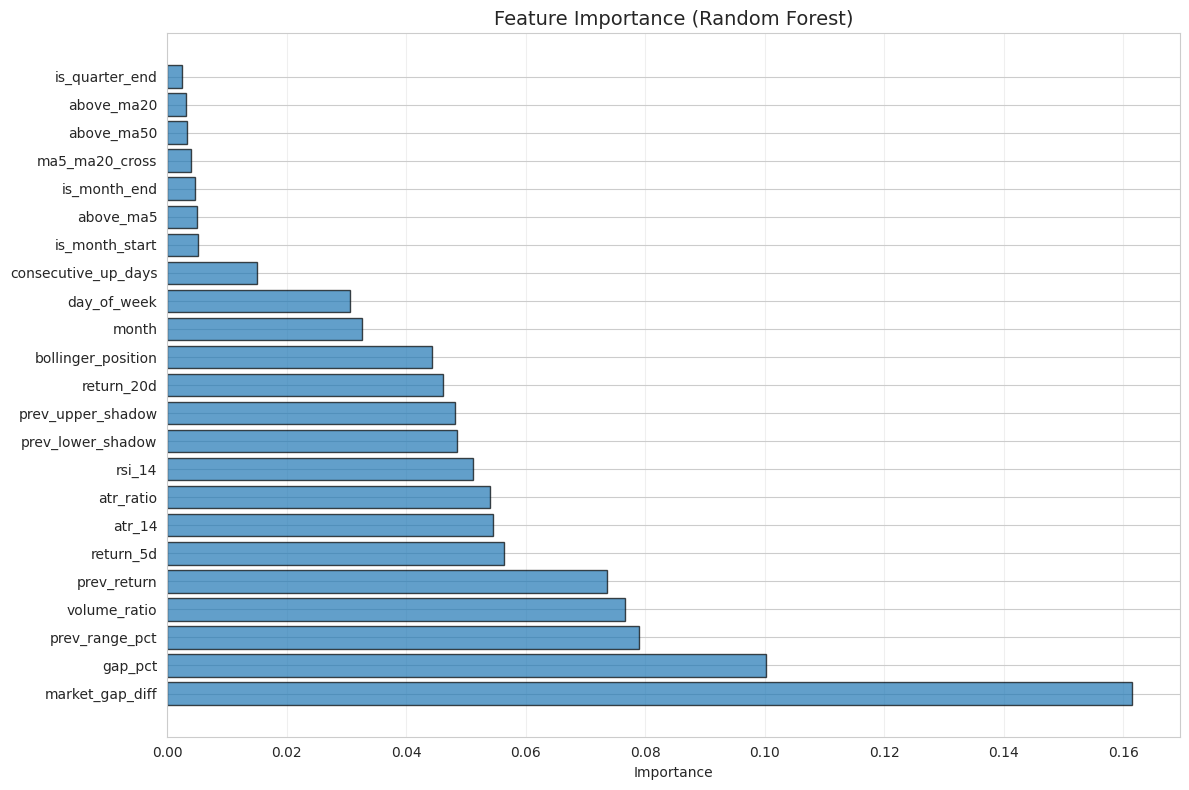


상위 10개 중요한 Features:
  market_gap_diff          : 0.1614
  gap_pct                  : 0.1002
  prev_range_pct           : 0.0789
  volume_ratio             : 0.0766
  prev_return              : 0.0736
  return_5d                : 0.0563
  atr_14                   : 0.0545
  atr_ratio                : 0.0540
  rsi_14                   : 0.0511
  prev_lower_shadow        : 0.0484


In [12]:
# Feature Importance 추출
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("=" * 80)
print("Feature Importance (Random Forest)")
print("=" * 80)
print(feature_importance.to_string(index=False))

# 시각화
plt.figure(figsize=(12, max(8, len(feature_importance) * 0.3)))
plt.barh(range(len(feature_importance)), feature_importance['importance'], 
         alpha=0.7, edgecolor='black')
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 상위 10개 출력
print("\n상위 10개 중요한 Features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']:25s}: {row['importance']:.4f}")

## 6. 모델 저장

In [13]:
# 모델 저장 경로
model_dir = Path("../models/classifier")
model_dir.mkdir(parents=True, exist_ok=True)

model_path = model_dir / "model_1_classifier.pkl"

# 모델 저장 (feature 정보와 함께)
model_metadata = {
    'model': model,
    'features': available_features,
    'optimal_threshold': optimal_threshold,
    'feature_importance': feature_importance,
    'split_method': 'random',  # ← 랜덤 분할 명시
    'split_ratio': '80:10:10',
    'test_metrics': {
        'accuracy': test_acc,
        'roc_auc': roc_auc_test,
        'ap_score': ap_test,
        'brier_score': brier_test,
        'threshold_04_precision': precision_04,
        'threshold_04_recall': recall_04,
        'threshold_04_f1': f1_04,
    },
    'hyperparameters': best_params,
    'created_at': datetime.now().isoformat()
}

joblib.dump(model_metadata, model_path)

print("=" * 80)
print("모델 저장 완료")
print("=" * 80)
print(f"저장 경로: {model_path}")
print(f"파일 크기: {model_path.stat().st_size / 1024 / 1024:.2f} MB")
print(f"\n저장된 정보:")
print(f"  - 모델: RandomForestClassifier")
print(f"  - Features: {len(available_features)}개")
print(f"  - Optimal Threshold: {optimal_threshold}")
print(f"  - Split Method: Random (80:10:10)")
print(f"  - Test AUC: {roc_auc_test:.4f}")
print(f"  - Test F1 (Threshold {optimal_threshold}): {f1_04:.4f}")

모델 저장 완료
저장 경로: ../models/classifier/model_1_classifier.pkl
파일 크기: 107.00 MB

저장된 정보:
  - 모델: RandomForestClassifier
  - Features: 23개
  - Optimal Threshold: 0.4
  - Split Method: Random (80:10:10)
  - Test AUC: 0.6415
  - Test F1 (Threshold 0.4): 0.5022


## 7. 최종 요약

In [14]:
print("=" * 80)
print("Model 1: 분류 모델 학습 완료")
print("=" * 80)

print("\n1. 데이터")
print(f"   - Train: {len(X_train):,} 샘플")
print(f"   - Valid: {len(X_valid):,} 샘플")
print(f"   - Test:  {len(X_test):,} 샘플")
print(f"   - Features: {len(available_features)}개")

print("\n2. 모델")
print(f"   - 알고리즘: Random Forest")
print(f"   - 트리 개수: {best_params['n_estimators']}")
print(f"   - 최대 깊이: {best_params['max_depth']}")
print(f"   - 클래스 가중치: {best_params['class_weight']}")

print("\n3. 성능 (Test Set)")
print(f"   - Accuracy: {test_acc:.4f}")
print(f"   - ROC AUC: {roc_auc_test:.4f}")
print(f"   - Average Precision: {ap_test:.4f}")
print(f"   - Brier Score: {brier_test:.4f}")

print(f"\n4. Threshold {optimal_threshold} 성능")
print(f"   - Precision: {precision_04:.4f}")
print(f"   - Recall: {recall_04:.4f}")
print(f"   - F1-Score: {f1_04:.4f}")

print("\n5. Feature Importance (Top 5)")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   {idx+1}. {row['feature']:25s}: {row['importance']:.4f}")

print("\n6. 다음 단계")
print("   - 05_modeling_regressor.ipynb: Model 2 & 3 (회귀 모델) 학습")
print("   - 06_model_integration.ipynb: 3개 모델 통합 (분류 + 회귀)")
print("   - 07_backtesting.ipynb: 백테스팅 시뮬레이션")

print("\n" + "=" * 80)
print("✓ 04_modeling_classifier.ipynb 완료")
print("=" * 80)

Model 1: 분류 모델 학습 완료

1. 데이터
   - Train: 120,330 샘플
   - Valid: 15,040 샘플
   - Test:  15,042 샘플
   - Features: 23개

2. 모델
   - 알고리즘: Random Forest
   - 트리 개수: 300
   - 최대 깊이: 15
   - 클래스 가중치: balanced

3. 성능 (Test Set)
   - Accuracy: 0.6435
   - ROC AUC: 0.6415
   - Average Precision: 0.4636
   - Brier Score: 0.2245

4. Threshold 0.4 성능
   - Precision: 0.3487
   - Recall: 0.8972
   - F1-Score: 0.5022

5. Feature Importance (Top 5)
   18. market_gap_diff          : 0.1614
   1. gap_pct                  : 0.1002
   3. prev_range_pct           : 0.0789
   6. volume_ratio             : 0.0766
   2. prev_return              : 0.0736

6. 다음 단계
   - 05_modeling_regressor.ipynb: Model 2 & 3 (회귀 모델) 학습
   - 06_model_integration.ipynb: 3개 모델 통합 (분류 + 회귀)
   - 07_backtesting.ipynb: 백테스팅 시뮬레이션

✓ 04_modeling_classifier.ipynb 완료
